In [93]:
import numpy as np
import matplotlib.pyplot as plt
import math
import random
import numpy as np
from scipy.signal import find_peaks


total time is 100.0


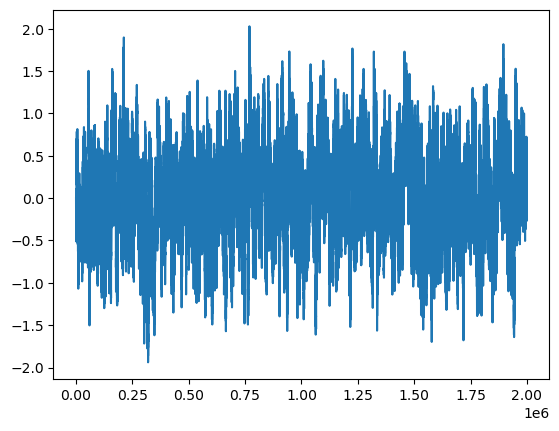

In [134]:
sampling_rate=2*1e4
sample_time=1/sampling_rate
N=2000000
def ou_noise(n, dt=1.0, mu=0.0, tau=20.0, sigma=1.0, x0=0.0, rng=None):
    rng = np.random.default_rng(rng)
    x = np.empty(n)
    x[0] = x0
    a = np.exp(-dt / tau)
    sd = sigma * np.sqrt(1 - a*a)
    for t in range(1, n):
        x[t] = mu + a*(x[t-1] - mu) + sd * rng.normal()
    return x
#I am setting tau to be 50ms

x = ou_noise(N, dt=sample_time, tau=100*1e-3, sigma=0.5)
plt.plot(x)
#print(10*1e-3/sample_time)
print("total time is",sample_time*N)

{0: {'I': 1000.0, 'Q': 1000.0}, 1: {'I': 2000.0, 'Q': 2000.0}, 2: {'I': 2999.9999999999995, 'Q': 2999.9999999999995}, 3: {'I': 4000.0, 'Q': 4000.0}, 4: {'I': 5000.0, 'Q': 5000.0}, 5: {'I': 5999.999999999999, 'Q': 5999.999999999999}, 6: {'I': 7000.0, 'Q': 7000.0}, 7: {'I': 8000.0, 'Q': 8000.0}, 8: {'I': 9000.0, 'Q': 9000.0}, 9: {'I': 10000.0, 'Q': 10000.0}}


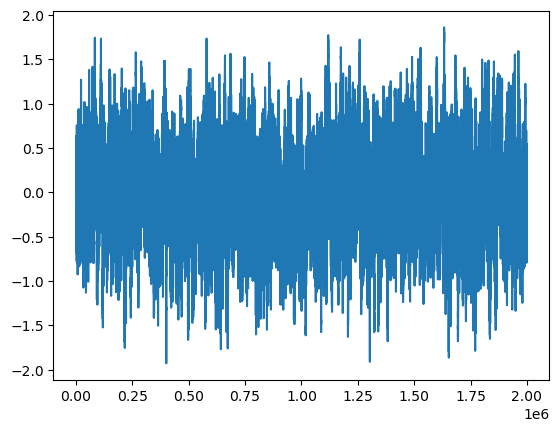

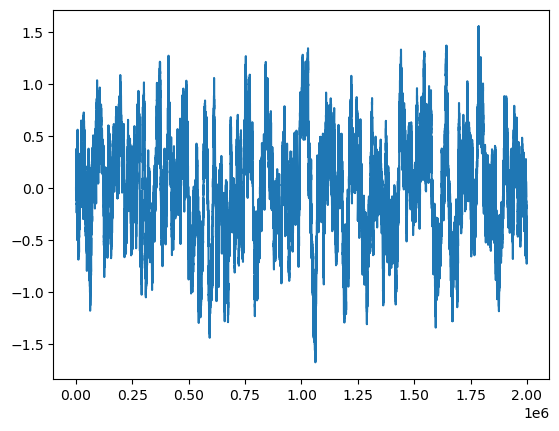

In [135]:
Channel_dict={}
num_channels=10
actual_coh_time={}
for i in range(10):
    tau_I=500*(i+1)
    tau_Q=500*(i+1)
    Channel_dict[i]={'I':ou_noise(N,dt=sample_time,tau=tau_I*1e-4,sigma=0.5),'Q':ou_noise(N,dt=sample_time,tau=tau_Q*1e-4,sigma=0.5)}
    actual_coh_time[i]={'I':tau_I*1e-4/sample_time,'Q':tau_Q*1e-4/sample_time}
print(actual_coh_time)

plt.plot(Channel_dict[0]["I"])
plt.show()
plt.plot(Channel_dict[9]["I"])

In [136]:
from numpy.fft import rfft, irfft

def autocorr_fft(x):
    x = np.asarray(x)
    x = x - x.mean()            # optional, improves robustness
    n = len(x)
    nfft = 1 << (2*n-1).bit_length()  # next pow2 for speed
    X = rfft(x, nfft)
    r = irfft(X * np.conj(X), nfft)[:n]   # non-negative lags
    r = r / (r[0] + 1e-20)      # normalize
    return r

def find_coh_time_fft(x, threshold=1e-2):
    r = autocorr_fft(x)
    # first lag where it drops below threshold
    idx = np.argmax(r <= threshold)  # returns 0 if first element meets
    if r[0] <= threshold:            # guard unlikely case
        return 0
    if idx == 0:                     # no drop found
        return len(r)                # cap at window length
    return idx

def find_coherence_time_per_channel(Wifi_symbol_dict):
    num_samples_per_coherence_detection=int(10/sample_time) #We need 50ms data for this
    t_coh_dict={}
    for channel in Wifi_symbol_dict:
        t_coh_dict[channel]={'I':0,'Q':0}
        i=0
        number_samples=len(Wifi_symbol_dict[channel]['I'])
        t_coh_distribution_arr_I=[]
        t_coh_distribution_arr_Q=[]
        while num_samples_per_coherence_detection*i<number_samples:
            #normalised_I_samples=Wifi_symbol_dict[channel]['I']
            I_curr_samples=Wifi_symbol_dict[channel]['I'][i*num_samples_per_coherence_detection:(i+1)*num_samples_per_coherence_detection]
            Q_curr_samples=Wifi_symbol_dict[channel]['Q'][i*num_samples_per_coherence_detection:(i+1)*num_samples_per_coherence_detection]
            t_coh_distribution_arr_I.append(find_coh_time_fft(I_curr_samples))
            t_coh_distribution_arr_Q.append(find_coh_time_fft(Q_curr_samples))
            i+=1
            #print(i)
         #break
        t_coh_dict[channel]['I']=np.mean(t_coh_distribution_arr_I)
        t_coh_dict[channel]['Q']=np.mean(t_coh_distribution_arr_Q)
    
    return t_coh_dict


# #print(find_coh_time_fft(x[:100000]))
print(find_coherence_time_per_channel(Channel_dict))
dict_coherence_times = find_coherence_time_per_channel(Channel_dict)
print("samples taken to find coherence",int(1/sample_time))

{0: {'I': 4278.9, 'Q': 3867.0}, 1: {'I': 7193.2, 'Q': 8687.4}, 2: {'I': 12341.4, 'Q': 10635.5}, 3: {'I': 11705.4, 'Q': 14781.6}, 4: {'I': 14940.2, 'Q': 13419.3}, 5: {'I': 16025.6, 'Q': 17124.7}, 6: {'I': 12891.9, 'Q': 21153.7}, 7: {'I': 24741.7, 'Q': 19918.4}, 8: {'I': 29910.5, 'Q': 27008.9}, 9: {'I': 20649.4, 'Q': 20783.6}}
samples taken to find coherence 20000


50882


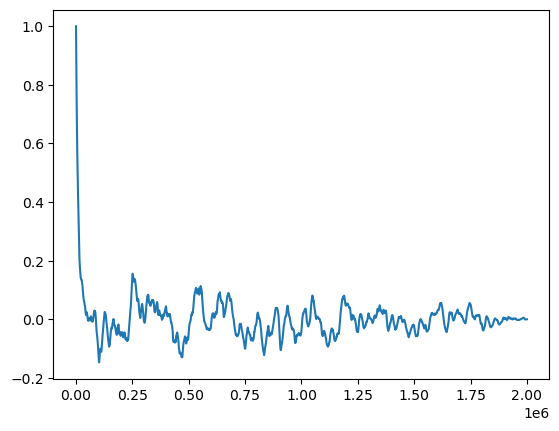

22310


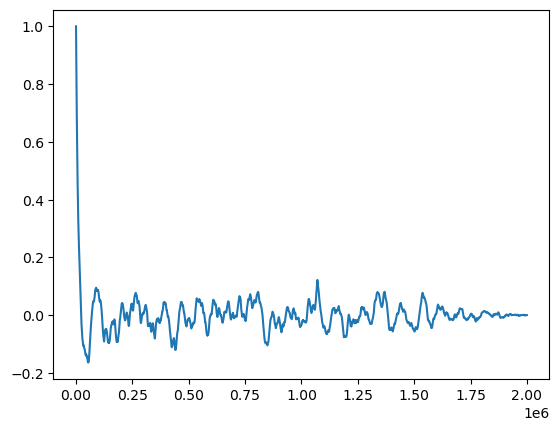

In [137]:
total_samples_plot=2000000
plt.plot(autocorr_fft(Channel_dict[8]["I"][:total_samples_plot]))
print(find_coh_time_fft(Channel_dict[8]["I"][:total_samples_plot]))
plt.show()
plt.plot(autocorr_fft(Channel_dict[9]["I"][:total_samples_plot]))
print(find_coh_time_fft(Channel_dict[9]["I"][:total_samples_plot]))


In [157]:
# multi armed bandit to select next channel to scan
#Right now the dwell time of stuff is around max 20000 samples

#we will create a coherence probability array
total_dwell_sum=0
for channel in dict_coherence_times:
    total_dwell_sum+=1/min(dict_coherence_times[channel]["I"],dict_coherence_times[channel]["Q"])

dwell_probabilities={}
for channel in dict_coherence_times:
    dwell_probabilities[channel]=(1/min(dict_coherence_times[channel]["I"],dict_coherence_times[channel]["Q"]))/total_dwell_sum

# check_sum=0
# for channel in dwell_probabilities:
#     check_sum+=dwell_probabilities[channel]

# print(check_sum)
print(dwell_probabilities)

#Using min dwell time as 0.5sec
min_dwell_samples=int(0.1/sample_time)
prob_1_dwell_samples=min_dwell_samples/min(dwell_probabilities.values())
print(prob_1_dwell_samples)

{0: 0.2788967916732872, 1: 0.14993242137026658, 2: 0.10140509551977825, 3: 0.09213644073680537, 4: 0.08036886375597846, 5: 0.06729819123156709, 6: 0.08365670641260028, 7: 0.05414560875374536, 8: 0.039931055814957345, 9: 0.05222882473101405}
50086.32902841606


In [158]:
# each channel is one arm
num_channels = 10 # number of arms

arm_coherent_time = {}

arm_dwell_time = {}
for channel in dwell_probabilities:
    arm_dwell_time[channel]=int(dwell_probabilities[channel]*prob_1_dwell_samples)    

arms_with_reward = {}
arm_last_played_time = {}
arm_coherent_time = {}

#We want dwell time min to be about 0.5sec

for i in range(num_channels):
    arms_with_reward[i] = 0
    arm_last_played_time[i] = 0
    arm_coherent_time[i] = min(dict_coherence_times[i]['I'], dict_coherence_times[i]['Q'])
    #arm_coherent_time[i] = random.randint(400, 1000)
    #arm_dwell_time[i] = int(1e7 / arm_coherent_time[i]) # seems correct

print(arm_dwell_time)


{0: 13968, 1: 7509, 2: 5079, 3: 4614, 4: 4025, 5: 3370, 6: 4190, 7: 2711, 8: 2000, 9: 2615}


In [147]:
# print(Channel_dict)
# print(len(Channel_dict))
# print(Channel_dict[9])
# print(len(Channel_dict[9]['I']))
# print(arm_coherent_time[1])

In [159]:
def selected_arm(epsilon):
    k = random.random()
    if (k < epsilon) : 
        next_arm = random.randint(0, num_channels-1)
    else:
        next_arm = max(arms_with_reward, key = arms_with_reward.get)
    return(next_arm)

# def selected_arm():
#     next_arm = max(arms_with_reward, key = arms_with_reward.get)
#     return(next_arm)

In [172]:
Wifi_output_samples={}
temp_output_samples = {}
for channel in Channel_dict:
    Wifi_output_samples[channel]={'I':[],'Q':[]}  # storing in the form of a list of elements (sample_num,value) for I and Q
epsilon = 0.5
# epsilon_decay = 0.995
total_samples = N

current_sample_index = 0
while(current_sample_index<total_samples):

    temp_output_samples = {}

    for i in range(num_channels):
        arms_with_reward[i] = get_reward(i, current_sample_index, arm_last_played_time, arm_coherent_time)
    next_arm = selected_arm(epsilon)
    temp_output_samples[next_arm] = {}
    temp_output_samples[next_arm]['I'] = []
    temp_output_samples[next_arm]['Q'] = []
    arms_with_reward[next_arm] = 0
    for i in range(arm_dwell_time[next_arm]):
        if current_sample_index==total_samples-1:
            current_sample_index+=1
            break
        Wifi_output_samples[next_arm]['I'].append([current_sample_index, Channel_dict[next_arm]['I'][current_sample_index]])
        Wifi_output_samples[next_arm]['Q'].append([current_sample_index, Channel_dict[next_arm]['Q'][current_sample_index]])
        temp_output_samples[next_arm]['I'].append(Channel_dict[next_arm]['I'][current_sample_index])
        temp_output_samples[next_arm]['Q'].append(Channel_dict[next_arm]['Q'][current_sample_index])
        current_sample_index+=1   

    # print(temp_output_samples)

    coh_time_to_update = find_coherence_time_per_channel(temp_output_samples)
    arm_coherent_time[next_arm] = min(coh_time_to_update[next_arm]['I'], coh_time_to_update[next_arm]['Q'])
    arm_dwell_time[next_arm] = int(((1/ arm_coherent_time[next_arm])/total_dwell_sum)*prob_1_dwell_samples) # seems correct
    print(arm_dwell_time)
    arm_last_played_time[next_arm] = current_sample_index

{0: 20036, 1: 19182, 2: 49512, 3: 9724, 4: 101346, 5: 17029, 6: 20246, 7: 52140, 8: 11466, 9: 32115}
{0: 20036, 1: 19182, 2: 49512, 3: 9724, 4: 101346, 5: 17029, 6: 20246, 7: 10476, 8: 11466, 9: 32115}
{0: 20036, 1: 19182, 2: 49512, 3: 9724, 4: 101346, 5: 17029, 6: 20246, 7: 10476, 8: 41361, 9: 32115}
{0: 20036, 1: 19182, 2: 49512, 3: 9724, 4: 101346, 5: 17029, 6: 20246, 7: 10476, 8: 41361, 9: 13314}
{0: 57773, 1: 19182, 2: 49512, 3: 9724, 4: 101346, 5: 17029, 6: 20246, 7: 10476, 8: 41361, 9: 13314}
{0: 57773, 1: 19182, 2: 49512, 3: 9724, 4: 101346, 5: 17029, 6: 20246, 7: 36998, 8: 41361, 9: 13314}
{0: 57773, 1: 19182, 2: 49512, 3: 9724, 4: 101346, 5: 17029, 6: 20246, 7: 36998, 8: 5322, 9: 13314}
{0: 26108, 1: 19182, 2: 49512, 3: 9724, 4: 101346, 5: 17029, 6: 20246, 7: 36998, 8: 5322, 9: 13314}
{0: 26108, 1: 19182, 2: 49512, 3: 9724, 4: 101346, 5: 17029, 6: 20246, 7: 36998, 8: 5322, 9: 27901}
{0: 26108, 1: 19182, 2: 49512, 3: 9724, 4: 101346, 5: 17029, 6: 20246, 7: 10267, 8: 5322, 9: 2

In [161]:
#print(arm_stddev)
#print(arm_mean_time)
# for i in range(num_channels):
#     print(Wifi_output_samples[i]['I'][:100])

print(arm_dwell_time)

{0: 20036, 1: 19182, 2: 49512, 3: 9724, 4: 101346, 5: 17029, 6: 20246, 7: 6148, 8: 11466, 9: 32115}


In [162]:
def get_sampled_channel(data,total_num_samples):
    "The input data is of the form [index,value] we need to be able to diffrentiate between periodic and non periodic signals to do this we are just linearly interpolating in stft"
    output_wifi_samples={}
    for channel in data:
        
        output_wifi_samples[channel]={'I':np.array([0 for i in range(total_num_samples)]),'Q':np.array([0 for i in range(total_num_samples)])}
        I = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['I']:
            idx = int(cur_sample)
            I[idx] = float(val)
        output_wifi_samples[channel]['I'] = I  # ensure the mutated array is stored
        Q = np.zeros(total_num_samples, dtype=np.float64)  # force float64
        for cur_sample, val in data[channel]['Q']:
            idx = int(cur_sample)
            Q[idx] = float(val)
        output_wifi_samples[channel]['Q'] = Q  # ensure the mutated array is stored

    return output_wifi_samples

output_samples_for_each_channel=get_sampled_channel(Wifi_output_samples,N)



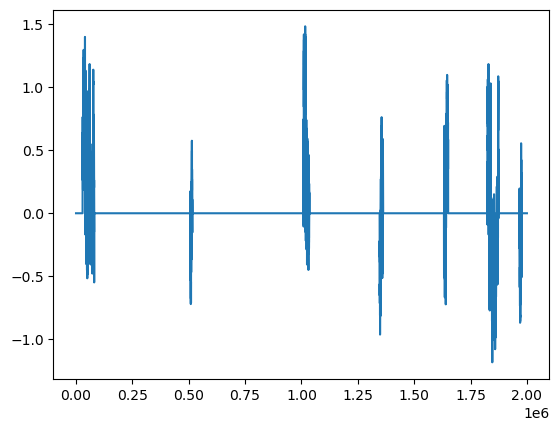

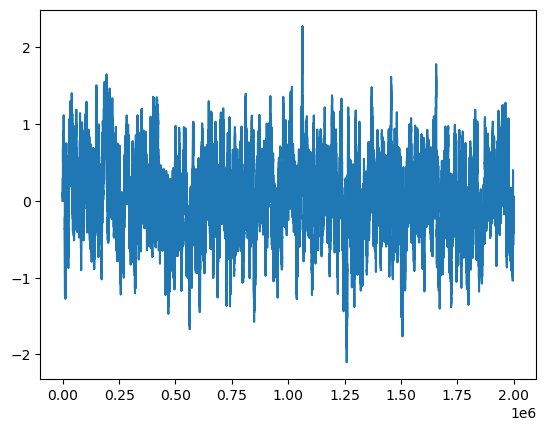

In [163]:
#plt.plot(output_samples_for_each_channel[1]['I'])
index=2
plt.plot(output_samples_for_each_channel[2]['I'])
plt.show()
plt.plot(Channel_dict[2]["I"])
#print(len())

Doing Naive method

In [164]:
Wifi_naive_symbols={}
size_of_naive_samples_per_channel=100000

cur_num=0
for channel in Channel_dict:
    Wifi_naive_symbols[channel]={'I':[],'Q':[]}

while cur_num<total_samples:
    for channel in Channel_dict:
        for i in range(size_of_naive_samples_per_channel):
            Wifi_naive_symbols[channel]['I'].append((cur_num,Channel_dict[channel]['I'][cur_num]))
            Wifi_naive_symbols[channel]['Q'].append((cur_num,Channel_dict[channel]['Q'][cur_num]))
            cur_num+=1
        #cur_num+=size_of_naive_samples_per_channel
        if cur_num>=total_samples:
            break
#I = np.zeros(2_000_000, dtype=np.float64)  # force float64
print(Wifi_naive_symbols[1]['I'][:100])
#Wifi_naive_symbols[channel]['I'] = I  # ensure the mutated array is stored


[(100000, 0.579059710895893), (100001, 0.5724051677830289), (100002, 0.557549427014645), (100003, 0.5433176334568629), (100004, 0.5272743792845578), (100005, 0.5475389325460662), (100006, 0.5545913572299475), (100007, 0.5554858236732791), (100008, 0.5651806761382437), (100009, 0.5843034729127141), (100010, 0.573079196186818), (100011, 0.5793170902327806), (100012, 0.5938666864346648), (100013, 0.611884042945564), (100014, 0.6235205303721237), (100015, 0.6228121713934963), (100016, 0.6237604978556176), (100017, 0.6264129864916793), (100018, 0.6434217113727171), (100019, 0.6582382077498949), (100020, 0.6781805873467627), (100021, 0.6904318162967119), (100022, 0.7207852497300966), (100023, 0.7319996236283364), (100024, 0.7601577155169784), (100025, 0.784836556626347), (100026, 0.795260798485846), (100027, 0.7678830005969806), (100028, 0.766477046796179), (100029, 0.7929391953310826), (100030, 0.7912226781999884), (100031, 0.8110212292214327), (100032, 0.8038399320463205), (100033, 0.81209

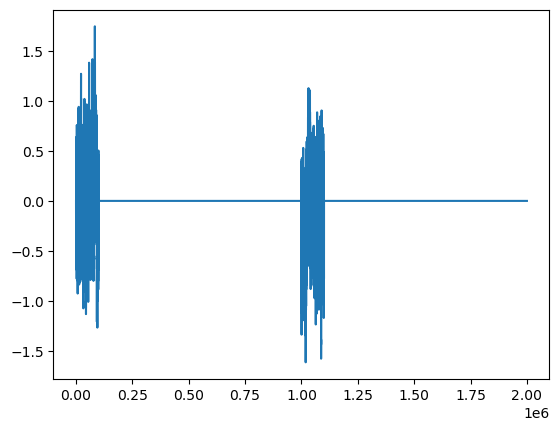

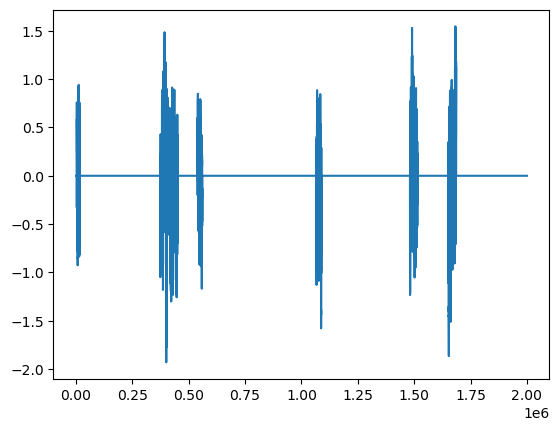

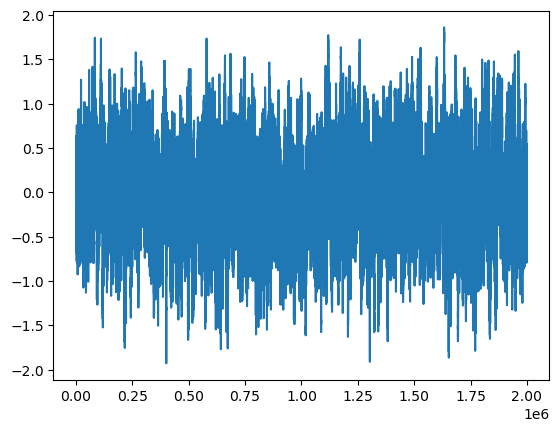

In [171]:
Wifi_output_data_after_interpolation_naive=get_sampled_channel(Wifi_naive_symbols,N)

index=0

plt.plot(Wifi_output_data_after_interpolation_naive[index]['I'])
plt.show()
plt.plot(output_samples_for_each_channel[index]['I'])
plt.show()
plt.plot(Channel_dict[index]["I"])